

### Convolutional Layer
The following chart shows the basic idea of processing an image in the first convolutional layer. The input image depicts the number 7 and four copies of the image are shown here, so we can see more clearly how the filter is being moved to different positions of the image. For each position of the filter, the dot-product is being calculated between the filter and the image pixels under the filter, which results in a single pixel in the output image. So moving the filter across the entire input image results in a new image being generated.
The red filter-weights means that the filter has a positive reaction to black pixels in the input image, while blue pixels means the filter has a negative reaction to black pixels.
In this case it appears that the filter recognizes the horizontal line of the 7-digit, as can be seen from its stronger reaction to that line in the output image.


### Imports

In [185]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
import time
from datetime import timedelta
import math

In [186]:
tf.__version__


'1.0.1'

### Configuration of Neural Network
The configuration of the Convolutional Neural Network is defined here for convenience, so you can easily find and change these numbers and re-run the Notebook.

In [187]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 42         # There are 42 of these filters.

# Convolutional Layer 2.
filter_size2 = 3          # Convolution filters are 4 x 4 pixels.
num_filters2 = 20         # There are 20 of these filters.

# Convolutional Layer 3.
filter_size3 = 3          # Convolution filters are 5 x 5 pixels.
num_filters3 = 100 

# Convolutional Layer 4.
filter_size4 = 3          # Convolution filters are 5 x 5 pixels.
num_filters4 = 10 

# Convolutional Layer 5.
filter_size5 = 3          # Convolution filters are 5 x 5 pixels.
num_filters5 = 10 

# Convolutional Layer 6.
filter_size6 = 5          # Convolution filters are 5 x 5 pixels.
num_filters6 = 1 

# Fully-connected layer.
fc_size = 100             # Number of neurons in fully-connected layer.

In [188]:
def convertToOneHot(labels, num_classes):
        one_hot = np.zeros((len(labels), num_classes))

        for i in range(len(labels)):
                j =int(labels[i][0])
                one_hot[i][j] = 1
        return np.array(one_hot)
        #print(one_hot)


In [189]:
new_array =[]
with open("data_jaffe/Labels/labels.txt", "r") as f:
    data =f.readlines()
    line =data[0]
    line =line.strip()
    val =line.split()
    for values in val:
       new_array.append(values)
  

In [190]:

labels = convertToOneHot(new_array,7)

In [191]:
labels.shape

(213, 7)

In [192]:
import scipy.misc

In [193]:
scipy.misc.imread

<function scipy.misc.pilutil.imread>

In [194]:
from PIL import Image
import glob,os

def image_vector(img_path):
    image =[]
    for infile in glob.glob( os.path.join(img_path, "*.tiff") ):
                img = Image.open(infile)
                new_list =list(img.getdata())
                image.append(new_list)
    return np.array(image)

In [195]:
image_path = 'data_jaffe/Images'
images =image_vector(image_path)

In [196]:
#train_images,test_images,train_labels,test_labels = X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)

In [197]:
a =images[:43]

In [198]:
b= images[86:]

In [199]:
train_images = np.concatenate((a,b))

In [200]:
test_images = images[43:86]

In [201]:
c =labels[:43,:]

In [202]:
d = labels[86:,:]

In [203]:
train_labels = np.concatenate((c,d))

In [204]:
test_labels =labels[43:86,:]

In [205]:
test_cls = np.argmax(test_labels, axis=1)


In [206]:
test_cls

array([3, 3, 4, 4, 4, 5, 5, 6, 6, 6, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 3, 3,
       3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 1, 1, 0, 0, 0, 2, 2, 2, 3, 3])

In [207]:
test_images.shape

(43, 65536)

In [208]:
train_images.shape

(170, 65536)

In [209]:
print(train_labels[:5,:])

[[ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]]


In [210]:
print(test_labels[:5,:])

[[ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]]


### Data Dimensions
The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.



In [211]:
# We know that MNIST images are 256 pixels in each dimension.
img_size = 256

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 7

In [212]:
# Helper function
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

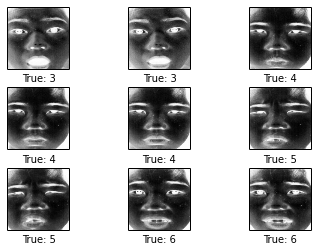

In [213]:
#plot images
# Get the first images from the test-set.
images = test_images[0:9]

# Get the true classes for those images.
cls_true =test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### TensorFlow Graph
The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.
TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.
TensorFlow can also take advantage of multi-core CPUs as well as GPUs - and Google has even built special chips just for TensorFlow which are called TPUs (Tensor Processing Units) and are even faster than GPUs.
A TensorFlow graph consists of the following parts which will be detailed below:
Placeholder variables used for inputting data to the graph.
Variables that are going to be optimized so as to make the convolutional network perform better.
The mathematical formulas for the convolutional network.
A cost measure that can be used to guide the optimization of the variables.
An optimization method which updates the variables.
In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.
### Helper-functions for creating new variables
Functions for creating new TensorFlow variables in the given shape and initializing them with random values. Note that the initialization is not actually done at this point, it is merely being defined in the TensorFlow graph.

In [214]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [215]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper-function for creating a new Convolutional Layer
This function creates a new convolutional layer in the computational graph for TensorFlow. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.
It is assumed that the input is a 4-dim tensor with the following dimensions:

1. Image number.
2. Y-axis of each image.
3. X-axis of each image.
4. Channels of each image.

Note that the input channels may either be colour-channels, or it may be filter-channels if the input is produced from a previous convolutional layer.
The output is another 4-dim tensor with the following dimensions:
1. number, same as input.
2. Y-axis of each image. If 2x2 pooling is used, then the height and width of the input images is divided by 2.
3. X-axis of each image. Ditto.
4. Channels produced by the convolutional filters.

In [216]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 2, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 3, 3, 1],
                               strides=[1, 2, 1, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights


### Helper-function for flattening a layer
A convolutional layer produces an output tensor with 4 dimensions. We will add fully-connected layers after the convolution layers, so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer.



In [217]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### Helper-function for creating a new Fully-Connected Layer
This function creates a new fully-connected layer in the computational graph for TensorFlow. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.
It is assumed that the input is a 2-dim tensor of shape [num_images, num_inputs]. The output is a 2-dim tensor of shape [num_images, num_outputs].

In [218]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Placeholder variables
Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.
First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to float32 and the shape is set to [None, img_size_flat], where None means that the tensor may hold an arbitrary number of images with each image being a vector of length img_size_flat.



In [219]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [220]:
#The convolutional layers expect x to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead 
#[num_images, img_height, img_width, num_channels]. Note that img_height == img_width == img_size and num_images can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [221]:
#Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder 
#variable x. The shape of this placeholder variable is [None, num_classes] which means it may hold an arbitrary number of labels and each label is a vector of length num_classes which is 10 in this case.
y_true = tf.placeholder(tf.float32, shape=[None, 7], name='y_true')

In [222]:
#We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. 
#Note that this is a TensorFlow operator so nothing is calculated at this point.

y_true_cls = tf.argmax(y_true, dimension=1)

In [223]:
y_true_cls[:5]

<tf.Tensor 'strided_slice_4:0' shape=(?,) dtype=int64>

### Convolutional Layer 1
Create the first convolutional layer. It takes x_image as input and creates num_filters1 different filters, each having width and height equal to filter_size1. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling.



In [224]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)


Check the shape of the tensor that will be output by the convolutional layer. It is (?, 86, 86, 42) which means that there is an arbitrary number of images (this is the ?), each image is 86 pixels wide and 86 pixels high, and there are 42 different channels, one channel for each of the filters.

In [225]:
layer_conv1


<tf.Tensor 'Relu_14:0' shape=(?, 128, 128, 42) dtype=float32>

In [226]:
layer_conv1 =tf.nn.lrn(input=layer_conv1, depth_radius=None, bias=None, alpha=None, beta=None, name=None)

In [227]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 3, 3, 1],
                               strides=[1, 2, 1, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights


### Convolutional Layer 2
Create the second convolutional layer, which takes as input the output from the first convolutional layer. The number of input channels corresponds to the number of filters in the first convolutional layer.




In [228]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

 Check the shape of the tensor that will be output from this convolutional layer. The shape is (?, 29, 29, 20) where the ? again means that there is an arbitrary number of images, with each image having width and height of 29 pixels, and there are 20 channels, one for each filter.




In [229]:
layer_conv2  


<tf.Tensor 'Relu_15:0' shape=(?, 64, 128, 20) dtype=float32>

In [230]:
layer_conv2 =tf.nn.lrn(input=layer_conv2, depth_radius=None, bias=None, alpha=None, beta=None, name=None)
 

### Convolutional Layer 3
Create the second convolutional layer, which takes as input the output from the second convolutional layer. The number of input channels corresponds to the number of filters in the second convolutional layer.


In [231]:
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=False)

In [232]:
layer_conv3

<tf.Tensor 'Relu_16:0' shape=(?, 64, 128, 100) dtype=float32>

### Convolutional Layer 4


In [233]:
layer_conv4, weights_conv4 = \
    new_conv_layer(input=layer_conv3,
                   num_input_channels=num_filters3,
                   filter_size=filter_size4,
                   num_filters=num_filters4,
                   use_pooling=False)

In [234]:
layer_conv4

<tf.Tensor 'Relu_17:0' shape=(?, 64, 128, 10) dtype=float32>

### Convolutional Layer 5


In [235]:
layer_conv5, weights_conv5 = \
    new_conv_layer(input=layer_conv4,
                   num_input_channels=num_filters4,
                   filter_size=filter_size5,
                   num_filters=num_filters5,
                   use_pooling=True)

In [236]:
layer_conv4

<tf.Tensor 'Relu_17:0' shape=(?, 64, 128, 10) dtype=float32>

### Convolution layer 6

In [237]:
layer_conv6, weights_conv6 = \
    new_conv_layer(input=layer_conv5,
                   num_input_channels=num_filters5,
                   filter_size=filter_size6,
                   num_filters=num_filters6,
                   use_pooling=False)

### Flatten Layer
The convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors.

In [238]:
layer_flat, num_features = flatten_layer(layer_conv4)


Check that the tensors now have shape (?, 4200) which means there's an arbitrary number of images which have been flattened to vectors of length 4200 each. Note that 4200 = 10 x 10 x 42.

In [239]:
layer_flat

<tf.Tensor 'Reshape_11:0' shape=(?, 81920) dtype=float32>

In [240]:
num_features


81920

### Fully-Connected Layer 1
Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is fc_size. ReLU is used so we can learn non-linear relations.




In [241]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

Check that the output of the fully-connected layer is a tensor with shape (?, 128) where the ? means there is an arbitrary number of images and fc_size == 128.



In [242]:
layer_fc1

<tf.Tensor 'Relu_20:0' shape=(?, 100) dtype=float32>

### Fully-Connected Layer 2

In [243]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [244]:
layer_fc2


<tf.Tensor 'add_23:0' shape=(?, 7) dtype=float32>

### Predicted Class
The second fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each element is limited between zero and one and the 10 elements sum to one. This is calculated using the so-called softmax function and the result is stored in y_pred.




In [245]:
y_pred = tf.nn.softmax(layer_fc2)

In [246]:
#The class-number is the index of the largest element.
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [247]:
y_pred_cls[:5]

<tf.Tensor 'strided_slice_5:0' shape=(?,) dtype=int64>

### Cost-function to be optimized
To make the model better at classifying the input images, we must somehow change the variables for all the network layers. To do this we first need to know how well the model currently performs by comparing the predicted output of the model y_pred to the desired output y_true.
The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the network layers.
TensorFlow has a built-in function for calculating the cross-entropy. Note that the function calculates the softmax internally so we must use the output of layer_fc2 directly rather than y_pred which has already had the softmax applied.

In [248]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [249]:
cost = tf.reduce_mean(cross_entropy)


### Optimization Method
Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the AdamOptimizer which is an advanced form of Gradient Descent.
Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.



In [250]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measures
We need a few more performance measures to display the progress to the user.
This is a vector of booleans whether the predicted class equals the true class of each image.

In [251]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)


In [252]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


### TensorFlow Run
Create TensorFlow session
Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [253]:
session = tf.Session()


In [254]:
#initialize variables
#The variables for weights and biases must be initialized before we start optimizing them.

session.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations
There are 55,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.
If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.



In [255]:
train_batch_size = 170


Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. The progress is printed every 100 iterations.



In [256]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
#         idx = np.random.randint(3000, size=150)
#         x_batch = train_images[idx,:]
#         y_true_batch = train_labels[idx,:]
        x_batch = train_images[:]
        y_true_batch = train_labels[:]
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time
    # Calculate the accuracy on the training-set.
   # accuracy = session.run(accuracy, feed_dict=feed_dict_train)
    # Print the time-usage.
     
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    #print("Training Accuracy:"+str(accuracy))


### Helper-function to plot example errors
Function for plotting examples of images from the test-set that have been mis-classified.



In [257]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = test_images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = test_cls[incorrect]
    
    # Plot the first 9 images.
#     plot_images(images=images[0:9],
#                 cls_true=cls_true[0:9],
#                 cls_pred=cls_pred[0:9])


### Helper-function to plot confusion matrix



In [258]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = test_cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


### Helper-function for showing the performance
Function for printing the classification accuracy on the test-set.
It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.
Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.



In [259]:
# Split the test-set into smaller batches of this size.
test_batch_size =43

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(test_images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images =test_images[i:j, :]

        # Get the associated labels.
        labels = test_labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = test_cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)


### Performance before any optimization
The accuracy on the test-set is very low because the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.

In [260]:
print_test_accuracy(show_example_errors=True)


Accuracy on Test-Set: 14.0% (6 / 43)
Example errors:


## Performance after 1 optimization iteration
optimize(num_iterations=1)


In [261]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  11.8%
Time usage: 0:00:30


In [262]:
print_test_accuracy()


Accuracy on Test-Set: 11.6% (5 / 43)


In [263]:
#100 iteration
optimize(num_iterations=99) # We already performed 1 iteration above.


Time usage: 0:41:42


In [264]:
#print_test_accuracy()


Accuracy on Test-Set: 53.5% (23 / 43)
Example errors:
Confusion Matrix:
[[0 0 0 6 0 0 0]
 [0 4 0 2 0 0 0]
 [0 0 5 2 0 0 0]
 [0 0 0 7 0 0 0]
 [0 0 0 0 4 2 0]
 [0 0 0 0 5 0 0]
 [0 0 0 0 3 0 3]]


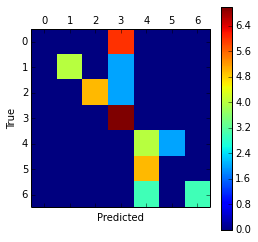

In [265]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)


In [266]:
#1000 iteration
optimize(num_iterations=400) # We performed 100 iterations above.


Optimization Iteration:    101, Training Accuracy: 100.0%
Optimization Iteration:    201, Training Accuracy: 100.0%
Optimization Iteration:    301, Training Accuracy: 100.0%
Optimization Iteration:    401, Training Accuracy: 100.0%
Time usage: 4:04:20


Accuracy on Test-Set: 51.2% (22 / 43)
Example errors:
Confusion Matrix:
[[0 0 0 6 0 0 0]
 [0 4 0 2 0 0 0]
 [0 0 4 3 0 0 0]
 [0 0 0 7 0 0 0]
 [0 0 0 0 4 2 0]
 [0 0 0 0 5 0 0]
 [0 0 0 0 3 0 3]]


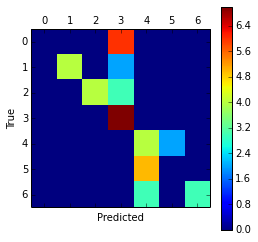

In [ ]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)


In [ ]:
optimize(num_iterations=200) # We performed 1000 iterations above.


Optimization Iteration:    501, Training Accuracy: 100.0%


In [ ]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)

In [ ]:
optimize(num_iterations=300) # We performed 1000 iterations above.


In [ ]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)

In [ ]:
optimize(num_iterations=200) # We performed 1000 iterations above.


In [ ]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)

In [ ]:
optimize(num_iterations=200) # We performed 1000 iterations above.


In [ ]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)

### Exercises
These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.
1. Do you get the exact same results if you run the Notebook multiple times without changing any parameters? What are the sources of randomness?
2. Run another 10,000 optimization iterations. Are the results better?
3. Change the learning-rate for the optimizer.
4. Change the configuration of the layers, such as the number of convolutional filters, the size of those filters, the number of neurons in the fully-connected layer, etc.
5. Add a so-called drop-out layer after the fully-connected layer. Note that the drop-out probability should be zero when calculating the classification accuracy, so you will need a placeholder variable for this probability.
6. Change the order of ReLU and max-pooling in the convolutional layer. Does it calculate the same thing? What is the fastest way of computing it? How many calculations are saved? Does it also work for Sigmoid-functions and average-pooling?
7. Add one or more convolutional and fully-connected layers. Does it help performance?
8. What is the smallest possible configuration that still gives good results?
9. Try using ReLU in the last fully-connected layer. Does the performance change? Why?
10. Try not using pooling in the convolutional layers. Does it change the classification accuracy and training time?
11. Try using a 2x2 stride in the convolution instead of max-pooling? What is the difference?
12. Remake the program yourself without looking too much at this source-code.
13. Explain to a friend how the program works.

## 